In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
pd.set_option('display.max_rows', 100)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight']= 'bold'


In [2]:
PATH_OCUS_EXPLAIN = Path("/home/emilio/research/OCUSExplain/")
PATH_POST_PAPER= PATH_OCUS_EXPLAIN / "conferences/2021_IJCAI/results/post_paper/output/" 
PATH_POST_PAPER_RESULTS = PATH_POST_PAPER / "2021050517/"
PATH_COSTS_RESUTS = PATH_POST_PAPER / "costs/"
PATH_FIGURES_POST_PAPER = Path("/home/emilio/research/holygrail/latex/conferences/ijcai21/paper/figures_post_paper/")

In [3]:
def replace_none(json_dict):
    new_json_dict = dict(json_dict)
    for k, v in json_dict.items():
        if isinstance(v, dict):
            new_json_dict[k] = replace_none(v)
            
        elif v is None:
            new_json_dict[k] = "ignore"
    
    return new_json_dict



In [4]:
def list_json_dir(folder):
    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.json']
    return files

def replace_none(json_dict):
    new_json_dict = dict(json_dict)
    for k, v in json_dict.items():
        if isinstance(v, dict):
            new_json_dict[k] = replace_none(v)
        elif v is None:
            new_json_dict[k] = "ignore"
    
    return new_json_dict

def read_json(f_path):
    with f_path.open('r') as fp:
        json_dict = json.load(fp)
        json_dict["filepath"] = f_path
        json_dict["filename"] = Path(f_path).name

    return replace_none(json_dict)

In [5]:

def pbs_to_params_dir(folder):

    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.pbs']
    pbs_param_dict = {}
    for f in files:
        path_file = p / f
        with path_file.open('r') as fp:
            for line in fp:
                if not line.startswith("python3"):
                    continue
                s = line.replace("python3 reuseSS.py --output ", "")
                result_json_fpath = s.split(" --puzzle ")[0]
                result_json_fpath = result_json_fpath.replace("/data/brussel/101/vsc10143/", "/home/emilio/research/")
                json_fname =    Path(result_json_fpath).name
                pbs_param_dict[json_fname] = str(p / str(f).replace(".pbs", ".json"))

    return pbs_param_dict


In [6]:
def jsonFilesToExtendedDf(jsonFiles, output_folder, param_matching=False):
    """ dictionary hierarchy
        'time' = {
            # number of hitting sets computed
            "totalTime": 0,
            # time spent in hitting set ?
            "hs": [],
            # time spent in optimising hitting set
            "opt": [],
            # time spent in sat
            "sat": [],
            # time spent in grow
            "grow": [],
            # time to find an explanation 
            "explain": [],
            # time propagating information
            "prop": [],
            # time spent in computing a MUS
            "mus":[],
            # time spent in computing a MUS
            "greedyBestStep":[],
            "preprocess":0,
            "preseeding":[],
            "postprocessing":[],
            "timeout": 0,
            "timedout": False
        },
        'numbers' = {
            # number of hitting sets computed
            "hs": [],
            # number of opt calls
            "opt": [],
            # number of sat calls
            "sat": [],
            # number of grow calls
            "grow": [],
            # number of literal explain calls skipped
            "skipped": [],
            # number of calls to propagation
            "prop": 0
        },
        'explanation': [
            'constraints': [], 'derived': [], 'cost': int}
        ]
    """
    if param_matching:
        input_folder = output_folder.replace("output/", "input/")
        pbs_params_dict = pbs_to_params_dir(input_folder)

    pd_dict = defaultdict(list)
    # prepopulate dictionary with good structure

    for f_json in jsonFiles:
        for k,v in f_json.items():
            if not isinstance(v, dict):
                pd_dict[k] = []
                continue

            for ki, vi in v.items():
                k_name = k + "_" + ki
                if k_name not in pd_dict:
                    pd_dict[k_name] = []

    for id, f_json in enumerate(jsonFiles):
        filled_keys = []
        for k,v in f_json.items():
            if not isinstance(v, dict):
                pd_dict[k].append(v)
                filled_keys.append(k)
                continue

            if k == 'time' and not 'timedout' in v:
                pd_dict['time_timedout'].append(True if v["totalTime"] == 7200 else False)
                filled_keys.append('time_timedout')

            for ki, vi in v.items():
                k_name = k + "_" + ki
                pd_dict[k_name].append(vi)
                filled_keys.append(k_name)

        for k in pd_dict:
            if k not in filled_keys:
                pd_dict[k].append("ignore")
    
        if param_matching:
            output_filename = f_json["filename"]
            params_path = pbs_params_dict[output_filename]
            params_f_json = read_json(Path(params_path))

            for k,v in params_f_json.items():
                key_params = "params_" + k
                if key_params not in pd_dict:
                    pd_dict[key_params] = []

                pd_dict[key_params].append(v)

    df = pd.DataFrame(pd_dict)

    return df


def folders_to_df(folders, param_matching=False, n=None):
    df = pd.DataFrame()

    for folder in folders:
        if n:
            files = [read_json(f) for f in list_json_dir(folder)[:n] if f.stat().st_size > 5]
        else:
            files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
        files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
        df_folder = jsonFilesToExtendedDf(files, folder, param_matching)
        df = df.append(df_folder)
    return df


In [7]:

def folder_to_pandas_df_pickle(output_folders, pickle_name="", param_matching=False, n=None):
    path_base_output_dir = "/home/emilio/research/OCUSExplain/experiments/data/output/"
    path_output_dirs = [path_base_output_dir + o for o in output_folders]
    df = folders_to_df(path_output_dirs, param_matching=param_matching, n=n)
    # df.to_pickle(pickle_name)
    return df

def best_puzzle_explanation_computer_config(df_not_timedout):
    df_min_query = df_not_timedout.groupby(["params_instance", "params_explanation_computer"])["time_totalTime"].idxmin()
    df_puzzle_computer = df_not_timedout.loc[df_min_query]

    return df_puzzle_computer

def best_puzzle_config(df_not_timedout):
    df_min_query = df_not_timedout.groupby(["params_instance"])["time_totalTime"].idxmin()
    df_puzzle_computer = df_not_timedout.loc[df_min_query]

    return df_puzzle_computer


In [8]:
def pickle_to_research_questions(pickle_path):
    df = pd.read_pickle(pickle_path)
    all_column_names = ['time_totalTime', 'time_hs', 'time_opt', 'time_sat', 'time_grow', 'time_explain', 'time_prop', 'time_mus', 'time_greedyBestStep', 'time_preprocess', 'time_preseeding', 'time_postprocessing', 'time_timedout', 'numbers_hs', 'numbers_opt', 'numbers_sat', 'numbers_grow', 'numbers_skipped', 'numbers_prop', 'explanation', 'filepath', 'filename', 'params_output', 'params_instance', 'params_timeout', 'params_explanation_computer', 'params_grow', 'params_maxsatpolarity', 'params_interpretation', 'params_weighing', 'params_reuse_SSes', 'params_sort_literals', 'params_filepath', 'params_filename']
    col_inst_time_config = ["params_instance", 'params_explanation_computer', "time_totalTime",'params_grow', 'params_maxsatpolarity', 'params_interpretation', 'params_weighing', 'params_reuse_SSes', 'params_sort_literals']

    # best configuration for all epxlnaation computers
    df_not_timedout = df[(df["time_totalTime"] < 7200) & (df["time_totalTime"] > 0)]

    df_not_timedout_not_MUS = df_not_timedout[df_not_timedout["params_explanation_computer"] != "MUS"]
    df_not_timedout_OCUS = df_not_timedout[df_not_timedout["params_explanation_computer"] == "OCUS"]

    # Best configuration for all explanation computer and all puzzles
    df_best_puzzle_computer_config = best_puzzle_explanation_computer_config(df_not_timedout)[col_inst_time_config]

    # Best configuraiton for all puzzles
    df_best_puzzle_config = best_puzzle_config(df_not_timedout)[col_inst_time_config]
    df_best_puzzle_config_not_MUS = best_puzzle_config(df_not_timedout_not_MUS)[col_inst_time_config]
    df_best_puzzle_config_OCUS = best_puzzle_config(df_not_timedout_OCUS)[col_inst_time_config]


## Applying transformations before plotting 
### 1. Enhancing the data

In [9]:
# ensure totTime is timeout
def cumul_expl_time(row):
    expl_time = row["texpl"]
    cumul_expl = []
    cumul_time = 0
    
    for t in expl_time:
        cumul_time += t
        cumul_expl.append(cumul_time)
    if row["timeout"]:
        cumul_expl.append(row["param_timeout"])
    return cumul_expl

def cumul_lits_derived(row):
    expls = row["explanation"]
    cumul_lits = 0
    cumul_lit_seq = []
    for explanation in expls:
        n_lits_derived = len(explanation["derived"])
        cumul_lits += n_lits_derived
        cumul_lit_seq.append(cumul_lits)
    return cumul_lit_seq

def lits_derived(row):
    expls = row["explanation"]
    lit_seq = []
    for explanation in expls:
        n_lits_derived = len(explanation["derived"])
        lit_seq.append(n_lits_derived)
    return lit_seq

def joint_lits_time(row):
    expls = row["expl_seq"]
    texpl = row["texpl"]
    lit_seq = []
    cumul_time = 0
    for explanation, time_expl  in zip(expls, texpl):
        cumul_time += time_expl
        n_lits_derived = len(explanation["derived"])
        lit_seq.append((cumul_time, n_lits_derived))
    
    if row["timeout"]:
        lit_seq.append((row["param_timeout"], 0))
    return lit_seq


def rename_config(row):
    if row["param_explanation_computer"] == "OCUS":
        if row["param_disableConstrained"]:
            return "OCUS"
        return "OCUS+I"
    elif row["param_explanation_computer"] == "OUS":
        if row["param_reuse_SSes"]:
            return "OUS+I"
        return "OUS"
    elif row["param_explanation_computer"] == "MUS":
        return "MUS"

def rename_grow_config(row):
    grow_renaming = {
        "MAXSAT":"Max",
        'SAT':"Sat", 
        'SUBSET_MAXIMAL':"Greedy-Sat-Full", 
        'SUBSET_MAXIMAL_I0': "Greedy-Sat-Initial", 
        'SUBSET_MAXIMAL_ACTUAL': "Greedy-Sat-Actual", 
        'ignore': "ignore",
        None: "ignore", 
    }
    if row["param_grow"] in ["SUBSET_MAXIMAL", "SUBSET_MAXIMAL_I0", "SUBSET_MAXIMAL_ACTUAL", 'ignore', None, "SAT"]:
        return grow_renaming[row["param_grow"]]

    weights_renaming = {
        'ACTUAL_UNIF': "Actual-Unif",
        'ACTUAL_INV': "Actual-Inv",
        'FULL_POS': "Full-Pos", 
        'FULL_UNIF': "Full-Unif",
        'INITIAL_INV': "Initial-Inv",
        'INITIAL_POS': "Initial-Pos", 
        'ACTUAL_POS': "Actual-Pos",
        'INITIAL_UNIF': "Initial-Unif",
        'FULL_INV':"Full-Inv", 
        'ignore':'ignore', 
        None: "ignore"
    }
    
    return grow_renaming[row["param_grow"]] + "-" + weights_renaming[row["param_weighing"]]


def average_lits_derived_time(row):
    penalty = 7200
    max_lits_puzzle = {
        'origin-problem':150,
         'p12':150,
         'p13':150,
         'p16':150,
         'p18':150,
         'p19':250,
         'p20':150,
         'p25':150,
         'p93':150,
         "frietkot":0,
         "simple":0,
         'pastaPuzzle':96
    }

    avg_lits_derived_times = [(0, 0)]
    j = 1
    tot_time = 0
    for lits_derived, texpl in zip(row["lits_derived"], row["time_explain"]):
        tot_time += texpl
        for i in range(lits_derived):
            avg_lits_derived_times.append((j,tot_time))
            j+= 1

    if row["time_timedout"]:
        tot_time = penalty
        for k in range(j, 251):
            avg_lits_derived_times.append((k, penalty))
        j = max_lits_puzzle[row["params_instance"]]

    elif j< 250:
        for i in range(j, 251):
            avg_lits_derived_times.append((i, tot_time))
            
    return avg_lits_derived_times

def mus_size(expl_seq):
    sizes = []
    for expl in expl_seq:
        size = len(expl["constraints"]) + 1
        sizes.append(size)
    
    return sizes


def cumulative_lits_derived_time(df):
    """Given a specific configuration plot the cumulative explanation time
    with respect to the number of ltierals derived."""
    assert len(set(df["param_explanation_computer"])) == 1, "making sure there is only 1 config"
    assert len(set(df["param_instance"])) == 10, "Making sure we have all puzzles"
    assert len(df) == 10, "Only 10 puzzle configs"
    x = [0]
    y = [0]
    times_lits_derived = []
    
    # one whole list
    for id, row in df.iterrows():
        times_lits_derived += row["joint_lits_time"]

    # sorting on cumulative time
    times_lits_derived.sort(key=lambda x: x[0])
    n_cumul_lits = 0

    # computing the 
    for (t, nlit) in times_lits_derived:
        n_cumul_lits += nlit
        y.append(t)
        x.append(n_cumul_lits)
    
    return x, y

def cumulative_expl_time(df):
    """Given a specific configuration plot the cumulative explanation time
    with respect to the number of ltierals derived."""
    assert len(set(df["param_explanation_computer"])) == 1, "making sure there is only 1 config"
    assert len(set(df["param_instance"])) == 10, "Making sure we have all puzzles"
    assert len(df) == 10, "Only 10 puzzle configs"

    expls_derived = [0]
    
    for id, row in df.iterrows():
        expls_derived += row["cumul_expl"]
    
    expls_derived.sort()
    x = list(range(len(expls_derived)))
    
    return x, expls_derived


def config_cumulative_exec_time(df):
    df_cumul = df.groupby(by=["params_explanation_computer"])["cumul_explain_time"].apply(lambda x : sorted(x.sum())).reset_index().rename(columns={'cumul_explain_time':'cumul_explain_time'})
    df_cumul["cumul_explain_step"] = df_cumul.apply(
                lambda row: [x for x in range(1, len(row["cumul_explain_time"])+1)]
        , axis=1)

    return df_cumul

def rename_grow_config(row):
    grow_renaming = {
        "MAXSAT":"Max",
        'SAT':"no-grow", 
        'SUBSETMAX':"Greedy", 
        'ignore': "ignore",
        None: "ignore", 
    }
    
    base_name = "" +grow_renaming[row["params_grow"]]

    if row["params_grow"] in ["SAT"]:
        return base_name
    
    inteprretiaon_renaming = {
        "FINAL": "Iend",
        "ACTUAL": "Actual",
        "FULL": "Full",
        "ignore": ""
    }
    
    weighing_renaming = {
        "UNIFORM": "Unif",
        "POSITIVE": "Pos",
        "INVERSE": "Inv",
        "ignore":""
     }
    if row["params_interpretation"] not in ["","ignore"]:
        base_name +="-" + inteprretiaon_renaming[row["params_interpretation"]]
    if row["params_weighing"] not in ["","ignore"]: 
        base_name +="-" + weighing_renaming[row["params_weighing"]]
    
    return base_name

def enhance_dataframe(df):
    df["lits_derived"] = df.apply(lambda row: lits_derived(row), axis=1)
    df["average_lits_derived_time"] = df.apply(lambda row: average_lits_derived_time(row), axis=1)
    df['cumul_explain_time'] = df.apply(
        lambda row: [sum(row["time_explain"][:x]) for x in range(1, len(row["time_explain"])+1)]
    , axis=1)
    df["params_grow_config"] = df.apply(lambda row: rename_grow_config(row), axis=1)
    df["params_explanation_config"] = df.apply(lambda row: rename_explanation_config(row), axis=1)
    
    return df

# Plotting the Data

In [13]:
def cactus_plot(df):
    display(df)
    plt.figure(figsize=(20, 12))
    for i, row in df.iterrows():
        x, y, label = row["cumul_explain_step"], row["cumul_explain_time"], row["params_explanation_computer"]
        plt.plot(x, y, label=label.replace('_','-'), linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    #plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative $\#$ of explanations",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    plt.title("Log-scaled cumulative explanation-time",fontsize=28)
    plt.grid(True)
    plt.show()


def cactus_plot_derived_lits(df):
    plt.figure(figsize=(20, 12))
    for i, row in df.iterrows():
        x, y, label = row["cumul_explain_step"], row["cumul_explain_time"], row["params_explanation_computer"]
        plt.plot(x, y, label=label.replace('_','-'), linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    #plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative $\#$ of literals",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    plt.title("Log-scaled cumulative derived literals time",fontsize=28)
    plt.grid(True)
    #plt.savefig("/home/emilio/research/OCUSExplain/code/pyexplain/benchmark/cactus_derived_lits" +datetime.now().strftime("%Y%m%d%H%M%S%f")+".png")
    plt.show()
    
def round_down(n, z):
    decimals = -1
    multiplier = 10 ** decimals
    return round(math.floor(n * multiplier) / multiplier)

def round_50(n, i=50):
    rounded = (n // i) * i
    return rounded

def heatMapCosts(ousCosts, musCosts, coeff_thick=1, figure_path=None):
    sizes = []
    x = []
    y = []
    for k in ousCosts:
        minlen = min(len(ousCosts[k]), len(musCosts[k]))
        x1 = ousCosts[k]
        y1 = musCosts[k]
        assert len(x1)==len(y1)
        x += x1
        y += y1
    
        d = {}
        for xi,yi in zip(x, y):
            if (xi, yi) in d:
                d[(xi, yi)] += coeff_thick
            else:
                d[(xi, yi)] = coeff_thick

        rounding = round_50
        num = 30
        xmin, xmax = min(x+y), max(x+y)
        all_vals = list(range(rounding(xmin, num), rounding(xmax+num, num), num))
    #     all_vals = list(set(rounding(l,num) for l in x + y))
        all_vals.sort()
        all_valsreversed = list(all_vals)
        all_valsreversed.sort(reverse=True)

        matx = [[0] * len(all_vals) for i in all_vals]


        for ((xi, yi), si) in d.items():

            xpos = all_vals.index(rounding(xi, num))
            ypos = all_valsreversed.index(rounding(yi, num))
            matx[ypos][xpos] = si

    #     fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(5,5))
        im = ax.imshow(matx, cmap='Greys', interpolation='nearest')

        # We want to show all ticks...
        ax.set_xticks(np.arange(len(all_vals)))
        ax.set_yticks(np.arange(len(all_vals)))
        # ... and label them with the respective list entries.
        xticksLabels = [str(val) if idx % 2 == 0 else "" for idx, val in  enumerate(all_vals) ]
        ax.set_xticklabels(xticksLabels,fontsize=16)
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        yticksLabels = list(xticksLabels)
        yticksLabels.reverse()
        ax.set_yticklabels(yticksLabels,fontsize=16)

        ax.plot(np.arange(len(all_vals)),range(len(all_vals)-1, -1, -1),linestyle='--')
        fig.tight_layout()
        # plt.xlim((0, 50))d
        plt.xlabel('OUS Explanation cost', fontsize=22)
        plt.ylabel('MUS Explanation cost', fontsize=22)
        vals= [60, 120, 200, 260, 380]
        valsreversed = [60, 120, 200, 260, 380]
        valsreversed.reverse()
        if figure_path:
            plt.savefig(figure_path, bbox_inches='tight')
        plt.show()

def plot_derived_lits_avg_time(d_vals, figure_path=None, figsize=(16, 8), mapping=None,  with_line = False,ordering=None,next_to_graph=False, loc=None):
    #
    ordered_d_vals = list(d_vals.keys())

    if ordering:
        ordered_d_vals = ordering
    
    plt.figure(figsize=figsize)
    if with_line:
        plt.plot(list(range(0, 251,1)), [7200]*251, linewidth=2, color='black', label='Timeout')
    for config in ordered_d_vals:
        if config not in d_vals:
            continue
        timings = d_vals[config]
        x = timings["x"]
        y = timings["y"]
        max_id = 251
        tt = False
#         for id, yi in enumerate(y):
#             if yi < 7180:
#                 max_id +=1
#             elif 7180 <= yi <= 7200 :
#                 tt = True
        label = config.replace('_','-')
        
        if mapping and config in mapping:
            label = mapping[config]

        if label in ["MUS"]:
            plt.plot(x[:max_id], y[:max_id], label=label, linewidth=3, linestyle="--")
            continue
    
        if tt:
            plt.plot(x[:max_id+1], y[:max_id]+[7180], label=label, linewidth=3)
        else:
            plt.plot(x[:max_id], y[:max_id], label=label, linewidth=3)

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    if next_to_graph:
        plt.legend(fontsize=19, loc='center left', bbox_to_anchor=(1.0, 0.55))
    elif loc:
        plt.legend(loc=loc, fontsize=19)
    else:
        plt.legend(loc="upper left", fontsize=19)

    plt.xlabel("Number of literals derived", fontsize=32)
    plt.ylabel("Avg. cumulative expl time [s]",fontsize=32)
   
    if figure_path:
        print("saving to path=", figure_path)
        plt.savefig(figure_path, bbox_inches='tight')
    
    plt.show()


def cactus_cumulative_lits_derived_time(df, column_name="params_explanation_config", figure_path=None, xlog=True, figsize=(16, 8), mapping=None, ordering=None,next_to_graph=False):
    plt.figure(figsize=figsize)
    
    all_column_values = set(df[column_name])
    
    x = []
    y = []
    max_y = []
    label = []

    if ordering:
        ordering_column_Values = ordering
    else:
        ordering_column_Values = all_column_values

    for id, column_value in enumerate(ordering_column_Values):
        xi, yi = cumulative_lits_derived_time(df[df[column_name] == column_value])
        x.append(xi)
        y.append(yi)
        if mapping:
            label.append(mapping[column_value])
        else:
            label.append(column_value)

        if int(max(yi)) < 7200:
            max_y.append((id, max(yi)))
        else:
            max_y.append((id, max(yi) + 10000 - max(xi)))

    if not ordering:
        max_y.sort(key=lambda xs: xs[1])
    
    for id, _ in max_y:
        plt.plot(x[id], y[id], label=label[id], linewidth=4)
    
    if next_to_graph:
        plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc="upper left", fontsize=20)

    if xlog:
        plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative number of literals derived",fontsize=26)
    plt.ylabel("Time [s]",fontsize=24)
    # plt.title("Cumulative Literals derived time",fontsize=28)
    plt.grid(True)
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

def cactus_cumulative_expl_time(df, column_name="params_explanation_config", figure_path=None, xlog=True, figsize=(16, 8), mapping=None, ordering=None,next_to_graph=False):
    plt.figure(figsize=figsize)
    
    all_column_values = set(df[column_name])
    x = []
    y = []
    max_y = []
    label = []

    
    if ordering:
        ordering_column_Values = ordering
    else:
        ordering_column_Values = all_column_values
        
    for id, column_value in enumerate(ordering_column_Values):
        xi, yi = cumulative_expl_time(df[df[column_name] == column_value])
        x.append(xi)
        y.append(yi)
        if mapping:
            label.append(mapping[column_value])
        else:
            label.append(column_value)
        
        if int(max(yi)) < 7200:
            max_y.append((id, max(yi)))
        else:
            max_y.append((id, max(yi) + 10000 - max(xi)))
    if not ordering:
        max_y.sort(key=lambda xs: xs[1])
    
    
    for id, my in max_y:
        plt.plot(x[id], y[id], label=label[id], linewidth=4)
    
    if next_to_graph:
        plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc="upper left", fontsize=20)

    if xlog:
        plt.xscale('log')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("Cumulative number of Explanation steps",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    # plt.title("Cumulative explanation-time",fontsize=28)
    plt.grid(True)
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()
    

# Importing Data from folder

In [15]:
output_folders = ["2021061714"]
pickle_name ="pickles/2021061714.pkl"

path_base_output_dir = "/home/emilio/research/OCUSExplain/experiments/data/output/"
path_output_dirs = [path_base_output_dir + o for o in output_folders]
df = folder_to_pandas_df_pickle(output_folders, pickle_name, False)

In [16]:
df = enhance_dataframe(df)

# Checking the quality of the generated explanations

In [41]:
selected_columns = [
    'time_totalTime',
 'params_instance',
 'params_explanation_computer',
 'params_maxsatpolarity',
 'params_reuse_SSes',
 'params_sort_literals',
 'params_disable_disjoint_mcses',
 'time_disjoint_MCSes',
 'numbers_disjoint_MCS_sets',
 'numbers_disjoint_MCS_units',
 'lits_derived',
 'average_lits_derived_time',
 'cumul_explain_time']
df_mus = df_paper[df_paper["params_explanation_computer"] =="MUS"]

df_paper_maxsat_all = df_paper[
    (df_paper["params_grow"] == "MAXSAT") & 
    (df_paper["params_weighing"] == "UNIFORM") &
    (df_paper["params_interpretation"] == "ACTUAL") 
]

df_paper_maxsat_cous = df_paper_maxsat_all[
    (df_paper_maxsat_all["params_explanation_computer"].isin(['MUS', 'OCUS_NOT_INCREMENTAL','OCUS']))
][selected_columns]
# display(df_paper_maxsat_cous)

df_paper_maxsat_ous = df_paper_maxsat_all[
    (df_paper_maxsat_all["params_explanation_computer"].isin([
        'OUS_INCREMENTAL_NAIVE', 'OUS_SS', 'OUS_SS+I', 'OUS_INCREMENTAL_SHARED'])) & 
    (df_paper_maxsat_all["params_sort_literals"] == True)
]

df_rq34 = df_mus.append([df_paper_maxsat_ous, df_paper_maxsat_cous])

# Summary Tables

saving to path= /home/emilio/research/holygrail/latex/conferences/ijcai21/paper/figures_post_paper/cumul_incr_avg_time_lits_derived_new.pdf


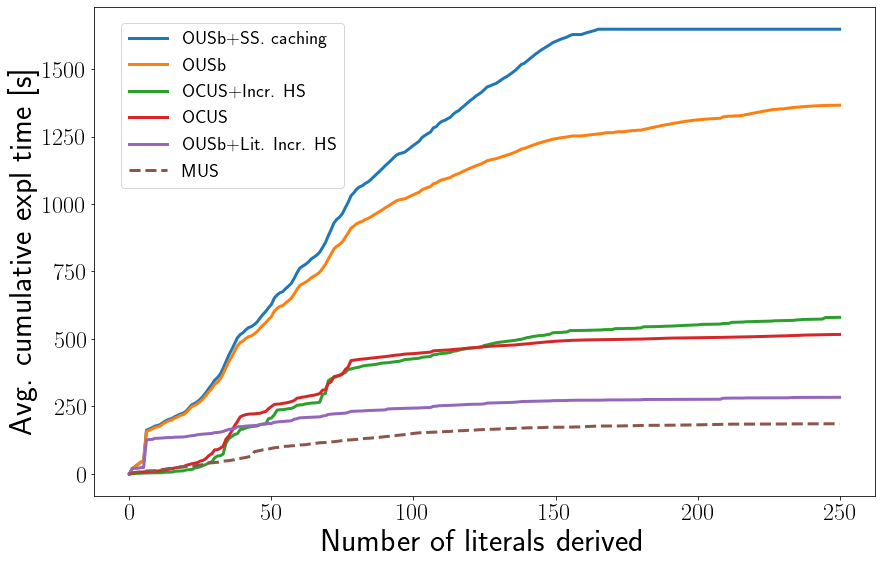

In [43]:
# init cumul average time per literal
from pathlib import Path
# dict with cumulative times
d_cumul_avg_time_incr = {config: {"x":None, "y": None} for config in set(df_rq34["params_explanation_computer"]) if config != "OUS_INCREMENTAL_SHARED"}

for config in set(df_rq34["params_explanation_computer"]):
    if config == "OUS_INCREMENTAL_SHARED":
        continue

    t_ordered = []
    # make it 1 graph
    for id, row in df_rq34[df_rq34["params_explanation_computer"]==config].iterrows():
        t_ordered+=row["average_lits_derived_time"]
    t_ordered.sort(key=lambda l: l[0])
    
    d_ordered = defaultdict(float)
    d_n_ordered = defaultdict(int)
    for step, ti in t_ordered:
        d_ordered[step] += ti
        d_n_ordered[step] += 1
        
    for step in d_ordered:
        d_ordered[step] /= d_n_ordered[step] 
    x=[]
    y=[]
    for step in sorted(d_ordered):
        x.append(step)
        y.append(d_ordered[step])

    d_cumul_avg_time_incr[config] = {"x": x, "y":y}
# display(df_rq34)

mapping = {"MUS": "MUS","OCUS": "OCUS","OCUS+I": "OCUS+Incr. HS","OUS": "OUS","OUS+I": "OUS+SS caching"}
paper_mapping = {
    'OCUS_NOT_INCREMENTAL':'OCUS', 
    'OUS_INCREMENTAL_NAIVE':'OUSb+Lit. Incr. HS', 
    'OUS_SS':'OUSb', 
    'OCUS':'OCUS+Incr. HS', 
    'MUS':'MUS', 
    'OUS_SS+I':'OUSb+SS. caching', 
    #'OUS_INCREMENTAL_SHARED':'OUS+Incr.HS+SS. Sharing'
}
paper_ordering = ['OUS_SS+I','OUS_SS','OCUS','OCUS_NOT_INCREMENTAL','OUS_INCREMENTAL_NAIVE',
    'MUS']
ordering = ["OUS+I", "OUS", "OCUS+I", "OCUS","MUS"]

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    figsize=(14, 9), 
    ordering=paper_ordering, 
    figure_path=Path(PATH_FIGURES_POST_PAPER) / "cumul_incr_avg_time_lits_derived_new.pdf",
    mapping=paper_mapping,
    loc=(0.035, 0.63),
    with_line = False,
    next_to_graph=False
)

In [44]:



df2["params_grow_config"] = df2.apply(lambda row: rename_grow_config(row), axis=1)

df2_cous = df2[
    df2["params_grow"].isin(['SAT', 'MAXSAT', 'SUBSETMAX']) & 
    (df2["params_explanation_computer"] =="OCUS") &
    (df2["params_instance"].isin(['p12', 'p13', 'p18', 'pastaPuzzle', 'p25', 'p20', 'p93', 'p16', 'origin-problem', 'p19']))
][[ 'params_instance',
 'params_explanation_computer',
   'params_weighing',
   'params_grow',
   "params_grow_config",
   'params_interpretation',
 'lits_derived',
 'average_lits_derived_time',
 'cumul_explain_time']]

saving to path= /home/emilio/research/holygrail/latex/conferences/ijcai21/paper/figures_post_paper/new_cumul_grow_avg_time_lits_derived_new.pdf


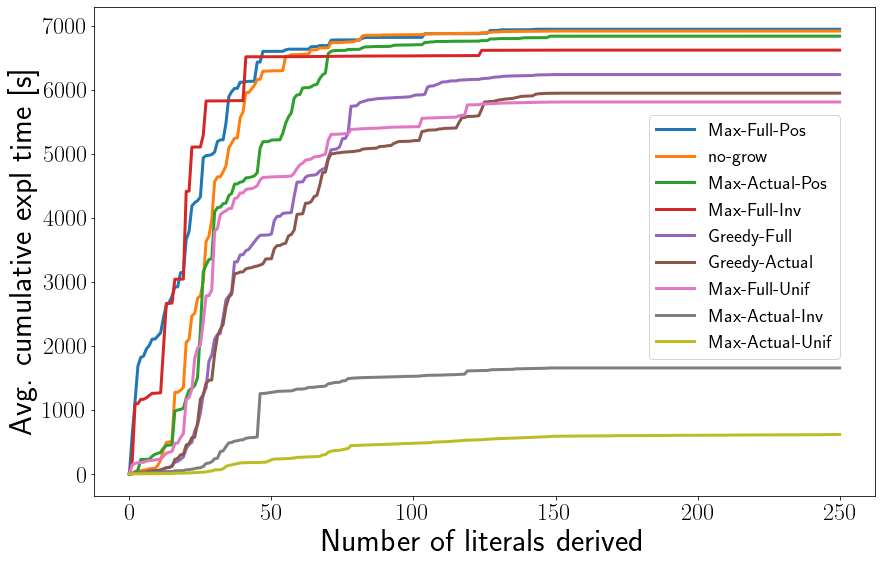

In [45]:
d_cumul_avg_time_grow_cous_incr = {}

for config in set(df2_cous["params_grow_config"]):
    t_ordered = []
    # make it 1 graph
    for id, row in df2_cous[df2_cous["params_grow_config"]==config].iterrows():
        t_ordered+=row["average_lits_derived_time"]
    t_ordered.sort(key=lambda l: l[0])
    
    d_ordered = defaultdict(float)
    d_n_ordered = defaultdict(int)

    for step, ti in t_ordered:
        d_ordered[step] += ti
        d_n_ordered[step] += 1
        
    
    for step in d_ordered:
        d_ordered[step] /= d_n_ordered[step] 
    
    x=[]
    y=[]
    for step in sorted(d_ordered):
        x.append(step)
        y.append(d_ordered[step])

    d_cumul_avg_time_grow_cous_incr[config] = {"x": x, "y":y}
    

grow_ordering = ['Max-Full-Pos','no-grow', 'Max-Actual-Pos','Max-Full-Inv', 'Greedy-Full', 'Greedy-Actual', 'Max-Full-Unif' , 'Max-Actual-Inv', 'Max-Actual-Unif'] 

plot_derived_lits_avg_time(
    d_cumul_avg_time_grow_cous_incr, 
    figsize=(14, 9), 
    ordering=grow_ordering, 
    figure_path=Path(PATH_FIGURES_POST_PAPER) / "new_cumul_grow_avg_time_lits_derived_new.pdf",
    #mapping=paper_mapping,
    loc=(0.71, 0.28),
    #next_to_graph=True,
     with_line = False,
)

Table 2: post-deadline, we realized that with the current fig 3, using
'OCUS+Incr HS' does not actually makes much sense, as it is only 3rd
best overall. I think we should replace it by OUS+LitIncrHS, or even
both OUS+LitIncrHS and OCUS. Or maybe even only OCUS (given that, if I'm
right, this one is not/barely incremental, so a run of OCUS in the
sequence or a run of OCUS on a given literal from scratch would be
rather similar?)

\begin{tabular}{c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c}
Time [s] &\textbf{0-1} & \textbf{1-2} & \textbf{2-3} & \textbf{3-5} & \textbf{5-10} & \textbf{10-20} & \textbf{20-50} & \textbf{50-100} & \textbf{100-200} & \textbf{200-500} & \textbf{500-1000} & \textbf{1000-1050} & \textbf{1050-1100} & \textbf{1100-1150} & \textbf{1150-1250} & \textbf{1250-1500} & \textbf{1500-1750} & \textbf{1750-2000} & \textbf{2000-5000}\\
\midrule
$\# expl$ &596 & 229 & 116 & 95 & 72 & 46 & 31 & 11 & 7 & 3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ %OCUS+Incr. HS
$\# expl$ &578 & 259 & 113 & 91 & 68 & 43 & 21 & 9 & 9 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ %OCUS
$\# expl$ &922 & 98 & 44 & 28 & 32 & 25 & 18 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\ %OUS+Lit. Incr. HS
\end{tabular}
$\# expl$ &31 & 103 & 109 & 207 & 333 & 239 & 112 & 28 & 5 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\ %OUS
$\# expl$ &6 & 32 & 57 & 155 & 472 & 184 & 134 & 38 & 13 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ %OUS+SS. caching


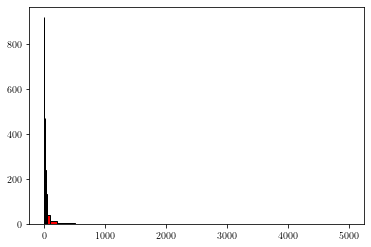

In [46]:
paper_mapping = {
    'OCUS_NOT_INCREMENTAL':'OCUS', 
    'OUS_INCREMENTAL_NAIVE':'OUS+Lit. Incr. HS', 
    'OUS_SS':'OUS', 
    'OCUS':'OCUS+Incr. HS', 
    'MUS':'MUS', 
    'OUS_SS+I':'OUS+SS. caching', 
    #'OUS_INCREMENTAL_SHARED':'OUS+Incr.HS+SS. Sharing'
}
for expl_computer in ["OCUS", "OCUS_NOT_INCREMENTAL", "OUS_INCREMENTAL_NAIVE", "OUS_SS", "OUS_SS+I"]:
    df_explanation_times = df_paper[
            (df_paper["params_grow"] == "MAXSAT") & 
            (df_paper["params_weighing"] == "UNIFORM") &
            (df_paper["params_interpretation"] == "ACTUAL") & 
            (df_paper["params_explanation_computer"] == expl_computer)
    ]
    if "OCUS" not in expl_computer:
        df_explanation_times = df_explanation_times[
            (df_explanation_times["params_sort_literals"] == True) 
        ]
    assert len(df_explanation_times) == 10, "10 puzzles exepcted, found = {}".format(len(df_explanation_times))
    df_explanation_times = df_explanation_times[["time_explain"]]
    explanation_times = []
    for id, row in df_explanation_times.iterrows():
        explanation_times += row["time_explain"]
    
    counts, bins, patches = plt.hist(explanation_times, bins=[0, 1, 2,3, 5, 10, 20, 50, 100, 200, 500, 1000,1050, 1100,1150, 1250, 1500, 1750,2000,5000], color='red', edgecolor='black')
    y = [int(c) for c in list(counts)]
    x = [int(c) for c in list(bins)]
    if expl_computer == "OCUS":
        header = [f"\\textbf{{{str(x[i-1])}-{str(x[i])}}}"for i in range(1, len(x)) ]
        print("\\begin{tabular}{" +  "c|"*(len(x)-1)+ "c}")
        print("Time [s] &" + " & ". join(header) + "\\\\")
        print("\\midrule")
    footer = [f"{str(y[i])}" for i in range(len(y))]
    print("$\# expl$ &" + " & ". join(footer) + "\\\\ %" + paper_mapping[expl_computer])
    if expl_computer == "OUS_INCREMENTAL_NAIVE":
        print("\\end{tabular}")

\begin{tabular}{c|c|c|c|c|c|c|c|c|c|c}
Time [s] &\textbf{0-1} & \textbf{1-2} & \textbf{2-3} & \textbf{3-5} & \textbf{5-10} & \textbf{10-20} & \textbf{20-50} & \textbf{50-100} & \textbf{100-200} & \textbf{200-500}\\
\midrule
$\# expl$ &596 & 229 & 116 & 95 & 72 & 46 & 31 & 11 & 7 & 3\\
\end{tabular}


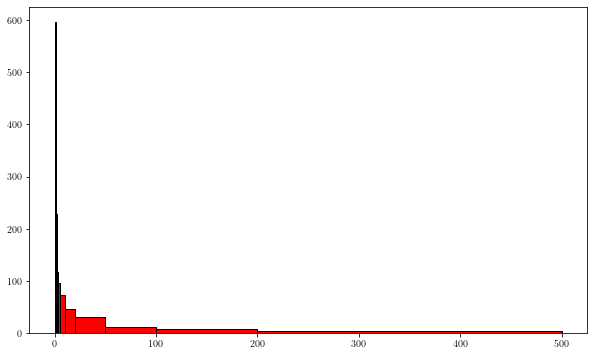

In [47]:
for expl_computer in ["OCUS", "OCUS_NOT_INCREMENTAL", "OUS_INCREMENTAL_NAIVE"]:
    
    df_explanation_times = df_paper[
        (df_paper["params_grow"] == "MAXSAT") & 
        (df_paper["params_weighing"] == "UNIFORM") &
        (df_paper["params_interpretation"] == "ACTUAL") & 
        (df_paper["params_explanation_computer"] == "OCUS")
    ][["time_explain"]]
    assert len(df_explanation_times) == 10, "10 puzzles exepcted, found = {}".format(len(df_explanation_times))

explanation_times = []
for id, row in df_explanation_times.iterrows():
    explanation_times += row["time_explain"]

fig, ax = plt.subplots(figsize=(10, 6))

counts, bins, patches = ax.hist(explanation_times, bins=[0, 1, 2, 3, 5, 10, 20, 50, 100, 200, 500], color='red', edgecolor='black')
y = [int(c) for c in list(counts)]
x = [int(c) for c in list(bins)]

header = [f"\\textbf{{{str(x[i-1])}-{str(x[i])}}}"for i in range(1, len(x)) ]
footer = [f"{str(y[i])}" for i in range(len(y))]
print("\\begin{tabular}{" +  "c|"*(len(x)-1)+ "c}")
print("Time [s] &" + " & ". join(header) + "\\\\")
print("\\midrule")
print("$\# expl$ &" + " & ". join(footer) + "\\\\")
print("\\end{tabular}")

In [48]:
selected_columns = [
    'time_totalTime',
     #'time_explain',
     'params_instance',
     'params_explanation_computer',
    'average_lits_derived_time',
    'lits_derived'
]

df_table_puzzle_config_mus = df[
    (df["params_explanation_computer"] == "MUS")
][selected_columns]

df_table_puzzle_config_cous = df[
    (
        df["params_explanation_computer"].isin(['OCUS', 'OCUS_NOT_INCREMENTAL']) & 
        (df["params_grow"] == "MAXSAT") & 
        (df["params_weighing"] == "UNIFORM") &
        (df["params_interpretation"] == "ACTUAL") & 
        (df["params_maxsatpolarity"] == True)
    )
][selected_columns]

df_table_puzzle_config_ous = df[
        (df["params_explanation_computer"].isin(
            ['OUS_INCREMENTAL_NAIVE', 'OUS_SS', 'OUS_SS+I'])
        ) & 
        (df["params_grow"] == "MAXSAT") & 
        (df["params_weighing"] == "UNIFORM") &
        (df["params_interpretation"] == "ACTUAL") & 
        (df["params_maxsatpolarity"] == True) &
        (df['params_sort_literals'] == True) 
][selected_columns]

df_table_config = df_table_puzzle_config_mus.append([df_table_puzzle_config_cous, df_table_puzzle_config_ous])
df_table_config["time_totalTime"] = df_table_config.apply(lambda row: round(row["time_totalTime"], 2), axis=1)

paper_mapping = {
    'OCUS_NOT_INCREMENTAL':'OCUS', 
    'OUS_INCREMENTAL_NAIVE':'OUS+Lit. Incr. HS', 
    'OUS_SS':'OUS', 
    'OCUS':'OCUS+Incr. HS', 
    'MUS':'MUS', 
    'OUS_SS+I':'OUS+SS. caching', 
    #'OUS_INCREMENTAL_SHARED':'OUS+Incr.HS+SS. Sharing'
}

rename_configs = lambda x: paper_mapping[x["params_explanation_computer"]]
df_table_config["params_explanation_computer"] = df_table_config.apply(lambda row: rename_configs(row), axis=1)
sum_isntances_configs = df_table_config.groupby("params_explanation_computer").agg(np.sum).reset_index()
sum_isntances_configs["params_instance"] = "sum"
sum_isntances_configs["time_totalTime"] = sum_isntances_configs.apply(lambda row: round(row["time_totalTime"], 2), axis=1)
df_table_config = df_table_config.append([sum_isntances_configs])

In [49]:
def replace_lits_derived(row):
    max_lits_puzzle = {
        'origin-problem':150,
         'p12':150,
         'p13':150,
         'p16':150,
         'p18':150,
         'p19':250,
         'p20':150,
         'p25':150,
         'p93':150,
         "frietkot":0,
         "simple":0,
         'pastaPuzzle':96
    }
    if row["time_totalTime"] == 7200:
        max_lits = max_lits_puzzle[row["params_instance"]]
        return f"---[{int(sum(row['lits_derived']))}/{max_lits}]---"
    return row["time_totalTime"]
        

df_table_config_with_derived = pd.DataFrame(df_table_config)
df_table_config_with_derived["time_totalTime"] = df_table_config_with_derived.apply(lambda row: replace_lits_derived(row), axis=1)
df_table_config_pivot_with_derived = pd.pivot_table(df_table_config_with_derived, values='time_totalTime', index=['params_instance'], columns=['params_explanation_computer'], aggfunc=np.sum)
df_table_config_pivot_with_derived = df_table_config_pivot_with_derived[
    ["MUS","OUS","OUS+Lit. Incr. HS","OUS+SS. caching", "OCUS","OCUS+Incr. HS"]
].reindex(['simple', 'frietkot', 'origin-problem', 'pastaPuzzle' , 'p12', 'p13', 'p16',  'p18', 'p19', 'p20','p25', 'p93'])


display(df_table_config_pivot_with_derived)


params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
simple,0.0,0.03,0.03,0.06,0.27,1.29
frietkot,0.01,0.06,0.04,0.06,1.3,1.7
origin-problem,140.24,821.67,95.41,970.55,320.09,293.18
pastaPuzzle,43.56,703.94,200.45,805.63,395.86,537.75
p12,117.54,848.84,132.81,1097.21,488.71,659.67
p13,153.49,1953.78,200.31,1997.63,1424.7,1485.62
p16,111.2,576.15,112.63,912.57,223.24,220.75
p18,112.35,592.73,85.94,675.7,102.34,73.81
p19,750.92,5918.25,1722.03,---[164/250]---,1621.02,1823.8


In [50]:
df_table_config_pivot = pd.pivot_table(df_table_config, values='time_totalTime', index=['params_instance'], columns=['params_explanation_computer'], aggfunc=np.sum)
#for id, row in df_table_config_pivot.iterrows():
#    print(sum(row.values))

df_table_config_pivot["sum"] = df_table_config_pivot.apply(lambda row: sum(row.values), axis=1)

df_table_config_pivot = df_table_config_pivot[
    ["MUS","OUS","OUS+Lit. Incr. HS","OUS+SS. caching", "OCUS","OCUS+Incr. HS", "sum"]
].reindex(['simple', 'frietkot', 'origin-problem', 'pastaPuzzle' , 'p12', 'p13', 'p16',  'p18', 'p19', 'p20','p25', 'p93', 'sum'])

display(df_table_config_pivot)


params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS,sum
params_instance,,,,,,,
simple,0.00,0.03,0.03,0.06,0.27,1.29,1.68
frietkot,0.01,0.06,0.04,0.06,1.30,1.70,3.17
origin-problem,140.24,821.67,95.41,970.55,320.09,293.18,2641.14
pastaPuzzle,43.56,703.94,200.45,805.63,395.86,537.75,2687.19
p12,117.54,848.84,132.81,1097.21,488.71,659.67,3344.78
p13,153.49,1953.78,200.31,1997.63,1424.70,1485.62,7215.53
p16,111.20,576.15,112.63,912.57,223.24,220.75,2156.54
p18,112.35,592.73,85.94,675.70,102.34,73.81,1642.87
p19,750.92,5918.25,1722.03,7200.00,1621.02,1823.80,19036.02


In [51]:
def time_to_derived_n(row, n):
    return row["average_lits_derived_time"][n][1]

def df_after_n(df, n):
    df_table_config_after_n = df.copy()
    df_table_config_after_n["average_lits_derived_time"] =df_table_config_after_n.apply(lambda row: time_to_derived_n(row, n), axis=1)
    return df_table_config_after_n

# 10 literals explained!
no_sum = pd.DataFrame(df_table_config[df_table_config["params_instance"] != "sum"])

for n in [10, 25, 50, 100, 150, 164, 165, 200]:
    df_n = df_after_n(no_sum, n)
    df_table_config_pivot_after_n = pd.pivot_table(df_n, values='average_lits_derived_time', index=['params_instance'], columns=['params_explanation_computer'], aggfunc=np.sum)
    df_table_config_pivot_after_n = df_table_config_pivot_after_n[
        ["MUS","OUS","OUS+Lit. Incr. HS","OUS+SS. caching", "OCUS","OCUS+Incr. HS"]
    ].reindex(['origin-problem', 'pastaPuzzle' , 'p12', 'p13', 'p16',  'p18', 'p19', 'p20','p25', 'p93'])
    print(f"\n\n\t\t\t--- Time to derive {n} literals ---\n")
    display(df_table_config_pivot_after_n)




			--- Time to derive 10 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,14.826169,61.372752,23.087870,61.375119,12.113291,2.223614
pastaPuzzle,6.659647,133.930105,78.701480,135.112952,9.539102,3.784760
p12,14.534655,52.431293,18.621099,54.453255,6.797773,2.938064
p13,12.399043,63.865280,28.110822,58.377627,4.931806,2.664613
p16,12.618214,39.858303,26.333215,47.601403,7.540820,3.983033
p18,10.862363,48.743962,19.688684,46.477619,6.409728,2.541390
p19,22.769649,1118.982295,1051.898432,1165.483006,2.646787,2.469006
p20,19.794100,57.772236,22.709020,60.877808,8.321466,2.813995
p25,9.742391,99.231902,30.234389,95.544671,41.785316,17.702614




			--- Time to derive 25 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,57.439051,166.563403,32.424451,170.055463,60.695160,33.100690
pastaPuzzle,22.992224,260.532692,121.716329,270.035501,52.397564,40.595335
p12,27.529341,119.783698,31.941538,126.716151,18.189780,12.987680
p13,45.597433,290.534338,47.600592,268.597370,139.452821,108.010917
p16,30.476487,127.276650,42.708811,157.724414,55.347673,17.544154
p18,31.371220,116.110513,29.983104,111.792553,14.532037,5.810367
p19,22.769649,1118.982295,1051.898432,1165.483006,2.646787,2.469006
p20,38.188369,110.638694,28.778769,119.031456,17.375617,9.315159
p25,28.001960,177.299612,46.396795,170.797860,74.542407,22.685110




			--- Time to derive 50 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,86.808932,399.033590,59.814889,417.673226,190.704072,123.212590
pastaPuzzle,34.593855,634.791487,190.373847,682.421073,371.736635,493.388810
p12,55.589912,363.276241,54.528862,398.274442,113.520231,105.761457
p13,100.693290,910.963928,118.016628,859.523161,1121.492142,906.860130
p16,53.272704,275.016199,59.634488,355.268900,121.727242,61.853242
p18,53.586737,239.589587,40.290749,239.021816,31.256820,12.065479
p19,229.860622,1952.572042,1124.366076,2215.794319,153.495259,34.643491
p20,73.432225,267.357425,44.657722,307.790624,55.717257,25.927554
p25,195.859321,395.877603,115.300262,386.580940,180.082099,193.982411




			--- Time to derive 100 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,125.579566,707.457508,77.478977,791.787379,286.290415,214.700648
pastaPuzzle,42.096981,701.347178,197.904097,803.107564,393.451498,533.917646
p12,99.583261,701.302562,109.600913,832.863330,443.592252,562.828012
p13,131.790375,1702.184108,157.698776,1654.416676,1363.984658,1321.813384
p16,92.722166,488.933269,94.627613,714.621879,189.774744,154.865093
p18,92.697600,444.160577,63.006966,469.142609,65.381012,36.534264
p19,479.907130,3705.205723,1417.171387,4776.483851,1152.612872,889.754622
p20,106.042924,526.200690,84.843616,649.360848,95.822740,69.983145
p25,227.359425,632.768822,134.210175,653.980453,228.156290,271.061618




			--- Time to derive 150 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,136.794637,814.738441,88.267969,964.079162,314.352722,285.577216
pastaPuzzle,42.096981,701.347178,197.904097,803.107564,393.451498,533.917646
p12,113.418274,841.496166,125.238498,1089.721489,482.416538,652.221152
p13,148.689351,1944.146091,191.506764,1988.722409,1416.488988,1477.877493
p16,107.388280,569.325352,105.711942,905.100892,216.513469,213.259258
p18,108.347237,585.428443,78.321944,668.304184,95.050302,65.848108
p19,589.602066,4629.449591,1552.605419,6746.873338,1328.975593,1219.078039
p20,119.429536,629.558331,99.851165,853.970692,121.175068,108.859567
p25,242.100861,744.428274,148.915069,828.109381,257.547865,347.371319




			--- Time to derive 164 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,136.794637,814.738441,88.267969,964.079162,314.352722,285.577216
pastaPuzzle,42.096981,701.347178,197.904097,803.107564,393.451498,533.917646
p12,113.418274,841.496166,125.238498,1089.721489,482.416538,652.221152
p13,148.689351,1944.146091,191.506764,1988.722409,1416.488988,1477.877493
p16,107.388280,569.325352,105.711942,905.100892,216.513469,213.259258
p18,108.347237,585.428443,78.321944,668.304184,95.050302,65.848108
p19,632.079841,4794.692276,1568.657166,7157.378079,1381.564774,1310.926318
p20,119.429536,629.558331,99.851165,853.970692,121.175068,108.859567
p25,242.100861,744.428274,148.915069,828.109381,257.547865,347.371319




			--- Time to derive 165 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,136.794637,814.738441,88.267969,964.079162,314.352722,285.577216
pastaPuzzle,42.096981,701.347178,197.904097,803.107564,393.451498,533.917646
p12,113.418274,841.496166,125.238498,1089.721489,482.416538,652.221152
p13,148.689351,1944.146091,191.506764,1988.722409,1416.488988,1477.877493
p16,107.388280,569.325352,105.711942,905.100892,216.513469,213.259258
p18,108.347237,585.428443,78.321944,668.304184,95.050302,65.848108
p19,636.507608,4805.917436,1569.559813,7200.000000,1385.276811,1312.302605
p20,119.429536,629.558331,99.851165,853.970692,121.175068,108.859567
p25,242.100861,744.428274,148.915069,828.109381,257.547865,347.371319




			--- Time to derive 200 literals ---



params_explanation_computer,MUS,OUS,OUS+Lit. Incr. HS,OUS+SS. caching,OCUS,OCUS+Incr. HS
params_instance,,,,,,
origin-problem,136.794637,814.738441,88.267969,964.079162,314.352722,285.577216
pastaPuzzle,42.096981,701.347178,197.904097,803.107564,393.451498,533.917646
p12,113.418274,841.496166,125.238498,1089.721489,482.416538,652.221152
p13,148.689351,1944.146091,191.506764,1988.722409,1416.488988,1477.877493
p16,107.388280,569.325352,105.711942,905.100892,216.513469,213.259258
p18,108.347237,585.428443,78.321944,668.304184,95.050302,65.848108
p19,682.591140,5328.121798,1600.786034,7200.000000,1458.218371,1503.805155
p20,119.429536,629.558331,99.851165,853.970692,121.175068,108.859567
p25,242.100861,744.428274,148.915069,828.109381,257.547865,347.371319


OUS_SS+I
OCUS_NOT_INCREMENTAL
OUS_NO_OPT+SS. Caching
OUS_INCREMENTAL_SHARED
OUS_INCREMENTAL_NAIVE
OCUS
OUS_NO_OPT
[(0, 0), (1, 338.8233244419098), (2, 680.2199456691742), (3, 680.2199456691742), (4, 680.2199456691742), (5, 680.2199456691742), (6, 1023.4151854515076), (7, 1023.4151854515076), (8, 1023.4151854515076), (9, 1023.4151854515076), (10, 1404.3362498283386), (11, 1776.156480550766), (12, 1776.156480550766), (13, 1776.156480550766), (14, 1776.156480550766), (15, 2194.4107718467712), (16, 2194.4107718467712), (17, 2194.4107718467712), (18, 2194.4107718467712), (19, 2634.0782840251923), (20, 3080.3233349323273), (21, 3554.0967648029327), (22, 4023.327734231949), (23, 4503.872727394104), (24, 5047.707314014435), (25, 5766.309597492218), (26, 5766.309597492218), (27, 5766.309597492218), (28, 5766.309597492218), (29, 6669.208978176117), (30, 6669.208978176117), (31, 6669.208978176117), (32, 6669.208978176117), (33, 7200), (34, 7200), (35, 7200), (36, 7200), (37, 7200), (38, 7200), (3

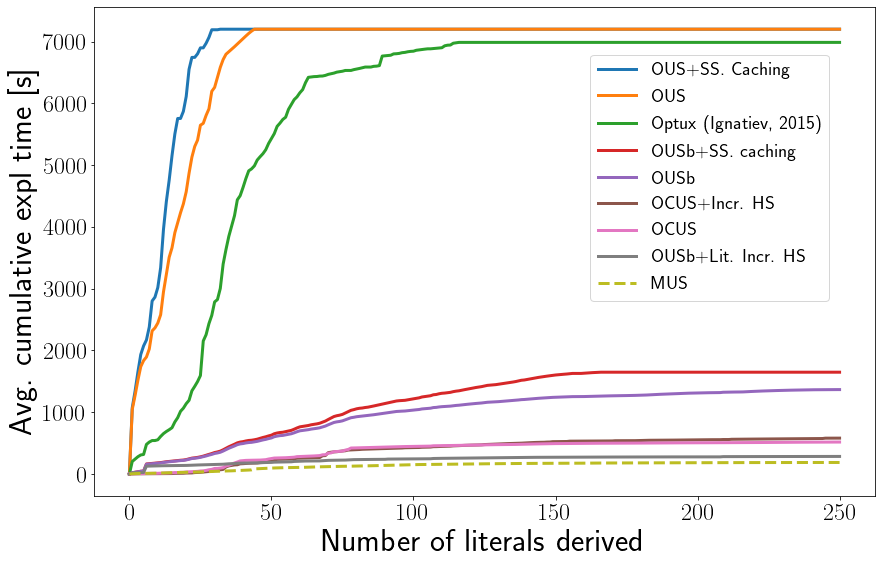

In [54]:
# init cumul average time per literal
from pathlib import Path
# dict with cumulative times
d_cumul_avg_time_incr = {config: {"x":None, "y": None} for config in set(df_rq34["params_explanation_computer"]) if config != "OUS_INCREMENTAL_SHARED"}

df_rq34_useful = df_rq34[[
    'time_totalTime',
 'params_instance',
 'params_explanation_computer',
 'lits_derived',
 'average_lits_derived_time',
 'cumul_explain_time']]


df_optux_rq34 = df_rq34_useful.append([df3_relevant, df4_ous_no_opt_relevant])

for config in set(df_optux_rq34["params_explanation_computer"]):
    print(config)
    if config == "OUS_INCREMENTAL_SHARED":
        continue
    
    
    t_ordered = []
    # make it 1 graph
    for id, row in df_optux_rq34[df_optux_rq34["params_explanation_computer"]==config].iterrows():
        if config == "OUS_NO_OPT":
            print(row["average_lits_derived_time"])
        t_ordered+=row["average_lits_derived_time"]
    t_ordered.sort(key=lambda l: l[0])
    
    d_ordered = defaultdict(float)
    d_n_ordered = defaultdict(int)
    for step, ti in t_ordered:
        d_ordered[step] += ti
        d_n_ordered[step] += 1
        
    for step in d_ordered:
        d_ordered[step] /= d_n_ordered[step] 
    x=[]
    y=[]
    for step in sorted(d_ordered):
        x.append(step)
        y.append(d_ordered[step])

    d_cumul_avg_time_incr[config] = {"x": x, "y":y}
# display(df_rq34)

mapping = {"MUS": "MUS","OCUS": "OCUS","OCUS+I": "OCUS+Incr. HS","OUS": "OUS","OUS+I": "OUS+SS caching"}
paper_mapping = {
    'OCUS_NOT_INCREMENTAL':'OCUS', 
    'OUS_INCREMENTAL_NAIVE':'OUSb+Lit. Incr. HS', 
    'OUS_SS':'OUSb', 
    'OCUS':'OCUS+Incr. HS', 
    'MUS':'MUS', 
    'OUS_SS+I':'OUSb+SS. caching',
    "OUS_NO_OPT+SS. Caching": "OUS+SS. Caching",
    "OPTUX_HITMAN":"Optux (Ignatiev, 2015)",
    "OUS_NO_OPT": "OUS"
    #'OUS_INCREMENTAL_SHARED':'OUS+Incr.HS+SS. Sharing'
}
paper_ordering = ["OUS_NO_OPT+SS. Caching","OUS_NO_OPT","OPTUX_HITMAN",'OUS_SS+I','OUS_SS','OCUS','OCUS_NOT_INCREMENTAL','OUS_INCREMENTAL_NAIVE',
    'MUS']
ordering = ["OUS+I", "OUS", "OCUS+I", "OCUS","MUS", "OPTUX_HITMAN","OUS_NO_OPT","OUS_NO_OPT+SS. Caching"]

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    figsize=(14, 9), 
    ordering=paper_ordering, 
    figure_path=Path(PATH_FIGURES_POST_PAPER) / "cumul_incr_avg_time_lits_derived_new_optux.pdf",
    mapping=paper_mapping,
    loc=(0.635, 0.4),
    with_line = False,
    next_to_graph=False
)